# Importing Necessary Libraries

In [2]:
# OS and Warning files
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.filterwarnings("ignore")

# Analysis Libraries
import pandas as pd
import numpy as np
import xgboost
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import svm, tree, ensemble, neighbors, linear_model
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV

# Visualization Library
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

%matplotlib inline

In [3]:
# plotly.tools.set_credentials_file(username='neelrast', api_key='tH7Ty1sAOwl8O3JnfLmf')

# Import RL Data

In [4]:
# Loading RL Features Dataset
storm_rl_df = pd.read_csv("../data/storm_rl_norm.csv")
storm_rl_df["cost_category"] = storm_rl_df["cost_category"].astype('category')
storm_rl_df.head()

,storm_names,eff_land_sp,direct,angled,cross,press_mbars,max_sust_winds_kts,storm_surge,storm_tide,moon_phase,low_neap,high_neap,high_ebb,high_tide_line,low_tide_line,norm_cost,cost_category
0,Bob,15.005262,0,1,0,1003,65,0.0,0.0,7,0,1,0,7.5,-0.6,5.963532e+05,moderate
1,Danny,12.080622,1,0,0,987,80,0.0,8.0,27,0,0,0,1.9,-0.4,1.250277e+06,high
2,Elena,19.448238,0,1,0,959,100,10.0,0.0,16,0,1,0,1.4,1.0,3.320953e+07,severe
3,Gloria,31.092933,0,0,0,942,90,0.0,0.0,12,1,0,0,1.3,0.3,0.000000e+00,minimal
4,Gloria,45.238814,0,1,0,961,75,0.0,0.0,12,0,0,0,3.0,0.2,0.000000e+00,minimal


In [5]:
storm_rl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 17 columns):
storm_names           115 non-null object
eff_land_sp           115 non-null float64
direct                115 non-null int64
angled                115 non-null int64
cross                 115 non-null int64
press_mbars           115 non-null int64
max_sust_winds_kts    115 non-null int64
storm_surge           115 non-null float64
storm_tide            115 non-null float64
moon_phase            115 non-null int64
low_neap              115 non-null int64
high_neap             115 non-null int64
high_ebb              115 non-null int64
high_tide_line        115 non-null float64
low_tide_line         115 non-null float64
norm_cost             115 non-null float64
cost_category         115 non-null category
dtypes: category(1), float64(6), int64(9), object(1)
memory usage: 14.8+ KB


In [6]:
storm_rl_df["moon_phase"] = abs(abs(storm_rl_df.moon_phase - 14)-7)

In [7]:
storm_rl_df["cost_category"].unique()

[moderate, high, severe, minimal, low, catastrophic]
Categories (6, object): [moderate, high, severe, minimal, low, catastrophic]

In [8]:
cateogry_types = ['low', 'minimal', 'moderate', 'high', 'severe',  'catastrophic']

storm_rl_df["cost_category_num"] = storm_rl_df.cost_category.astype("category", categories=cateogry_types).cat.codes

In [9]:
#Loading winds and rain data
winds_rain = pd.read_csv("../data/wind_rain.csv")
winds_rain = winds_rain.drop(columns={"Rain Rate"})
winds_rain.head()

,storm_names,year,month,day,Max Radii,Point Maxima
0,Bob,1985,7,25,NaN,21.50
1,Danny,1985,8,15,NaN,9.80
2,Elena,1985,9,2,NaN,15.67
3,Gloria,1985,9,27,NaN,9.70
4,Gloria,1985,9,27,NaN,9.70


In [10]:
winds_rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 6 columns):
storm_names     115 non-null object
year            115 non-null int64
month           115 non-null int64
day             115 non-null int64
Max Radii       104 non-null float64
Point Maxima    115 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 5.5+ KB


In [11]:
winds_rain = winds_rain.fillna(0)

In [12]:
storm_rl_df["year"] = winds_rain.year
storm_rl_df["month"] = winds_rain.month
storm_rl_df["day"] = winds_rain.day
storm_rl_df["Max Radii"] = winds_rain["Max Radii"]
storm_rl_df["Point Maxima"] = winds_rain["Point Maxima"]

In [13]:
storm_rl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 23 columns):
storm_names           115 non-null object
eff_land_sp           115 non-null float64
direct                115 non-null int64
angled                115 non-null int64
cross                 115 non-null int64
press_mbars           115 non-null int64
max_sust_winds_kts    115 non-null int64
storm_surge           115 non-null float64
storm_tide            115 non-null float64
moon_phase            115 non-null int64
low_neap              115 non-null int64
high_neap             115 non-null int64
high_ebb              115 non-null int64
high_tide_line        115 non-null float64
low_tide_line         115 non-null float64
norm_cost             115 non-null float64
cost_category         115 non-null category
cost_category_num     115 non-null int8
year                  115 non-null int64
month                 115 non-null int64
day                   115 non-null int64
Max Radii          

## Data Exploration

In [31]:
storm_rl_df.groupby(storm_rl_df["cost_category"]).count()

,storm_names,eff_land_sp,direct,angled,cross,press_mbars,max_sust_winds_kts,storm_surge,storm_tide,moon_phase,...,high_ebb,high_tide_line,low_tide_line,norm_cost,cost_category_num,year,month,day,Max Radii,Point Maxima
cost_category,,,,,,,,,,,,,,,,,,,,,
catastrophic,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
high,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
low,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
minimal,48,48,48,48,48,48,48,48,48,48,...,48,48,48,48,48,48,48,48,48,48
moderate,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
severe,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17


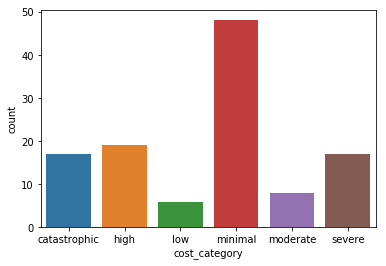

In [15]:
ax = sns.countplot(storm_rl_df["cost_category"],label="Count")

In [37]:
storm_rl_df['year'].value_counts()

2004    10
1998     8
2005     8
1985     7
2002     7
2008     6
1995     6
2017     6
1999     5
1996     4
2006     4
2012     4
2003     4
2001     3
2011     3
1989     3
1992     3
1994     3
1986     2
1991     2
2015     2
1997     2
2000     2
2016     2
2007     2
2010     1
2014     1
1993     1
2013     1
1988     1
1987     1
2009     1
Name: year, dtype: int64

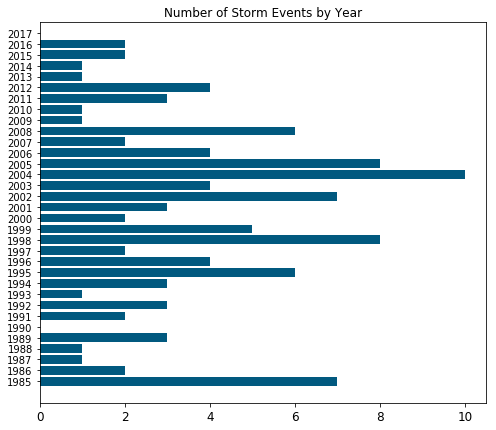

In [36]:
plt.figure(figsize=(8,7))
plt.barh(storm_rl_df['year'].value_counts().sort_index().index[:-1], 
         storm_rl_df['year'].value_counts().sort_index().values[:-1], color = '#01597f')
plt.title('Number of Storm Events by Year', fontsize = 12)
plt.yticks(np.arange(1985,2018,1), fontsize = 10)
plt.xticks(fontsize = 12);

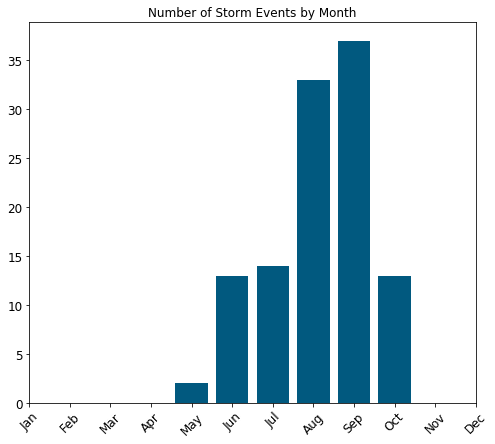

In [17]:
plt.figure(figsize=(8,7))
plt.bar(storm_rl_df['month'].value_counts().sort_index().index[:-1], 
         storm_rl_df['month'].value_counts().sort_index().values[:-1], color = '#01597f')
plt.title('Number of Storm Events by Month', fontsize = 12)
plt.xticks(range(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
           rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12);

In [18]:
coordinates = pd.read_csv("../data/storm_main.csv")

In [19]:
coordinates = coordinates.drop(columns={'time', 'zone', 'max_winds_kts', 'SS', 'pre_lat', 'pre_long', 'sub_lat',
       'sub_long', 'dir', 'sp1', 'sp2', 'frame', 'hours', 'eff_wind_sp',
       'angle_binary', 'direct', 'angled', 'cross', 'press_mbars',
       'max_sust_winds_kts', 'width_storm', 'storm_surge', 'storm_tide',
       'moon_phase', 'tide_phase', 'low_neap', 'high_neap', 'high_ebb',
       'high_tide_line', 'low_tide_line', 'rate_rainfall', 'total_rainfall',
       'deaths', 'states_affected', 'damage_unadj', 'col_index',
       'infaltion_adj'})
coordinates["norm_cost"] = storm_rl_df["norm_cost"]
coordinates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 7 columns):
storm_names    115 non-null object
year           115 non-null int64
month          115 non-null int64
day            115 non-null int64
lat_n          115 non-null float64
long_w         115 non-null float64
norm_cost      115 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 6.4+ KB


In [20]:
coordinates['text'] = 'Hurricane ' + coordinates['storm_names'] + '<br>Occured on ' + coordinates['month'].astype('str') + '/' + coordinates['day'].astype('str') + '/' + coordinates['year'].astype('str') + ' <br>Norm. Damage '  +  coordinates['norm_cost'].map('${:,}'.format).astype('str')

scl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
    [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"] ]

data = [go.Scattergeo(
        locationmode = 'USA-states',
        lon = -1*coordinates['long_w'],
        lat = coordinates['lat_n'],
        text = coordinates['text'],
        mode = 'markers',
        marker = dict( 
            size = 8, 
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = 0,
            color = coordinates['norm_cost'],
            cmax = coordinates['norm_cost'].max(),
            colorbar=dict(
                title="Normalized Damage caused by Storm Events <br> since 1985 till 2018"
            )
        ))]

layout = dict(
        title = 'Coordinates of Storm Events which caused land slides at point of impact.', 
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5        
        ),
    )

fig = go.Figure(data=data, layout=layout )
py.iplot(fig, filename='storm-events')

/Users/neelrast/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [21]:
# X_rl -> features
# y_rl -> labels

X_rl = storm_rl_df.drop(columns={"storm_names","year","month","day","norm_cost","cost_category","cost_category_num"})
y_rl = storm_rl_df["cost_category_num"]
classes = pd.merge(y_rl, storm_rl_df["cost_category"], left_index=True,  right_index =True)

In [22]:
X_rl.head()

,eff_land_sp,direct,angled,cross,press_mbars,max_sust_winds_kts,storm_surge,storm_tide,moon_phase,low_neap,high_neap,high_ebb,high_tide_line,low_tide_line,Max Radii,Point Maxima
0,15.005262,0,1,0,1003,65,0.0,0.0,0,0,1,0,7.5,-0.6,0.0,21.50
1,12.080622,1,0,0,987,80,0.0,8.0,6,0,0,0,1.9,-0.4,0.0,9.80
2,19.448238,0,1,0,959,100,10.0,0.0,5,0,1,0,1.4,1.0,0.0,15.67
3,31.092933,0,0,0,942,90,0.0,0.0,5,1,0,0,1.3,0.3,0.0,9.70
4,45.238814,0,1,0,961,75,0.0,0.0,5,0,0,0,3.0,0.2,0.0,9.70


## Classifiers

In [160]:
classifiers = []

model1 = xgboost.XGBClassifier()
classifiers.append(['XGBoost', model1])

model2 = svm.SVC(kernel = 'linear', C = 1)
classifiers.append(['SVM', model2])

model3 = tree.DecisionTreeClassifier()
classifiers.append(['Decision Trees', model3])

model4 = ensemble.RandomForestClassifier(max_depth = 10)
classifiers.append(['Random Forest', model4])

model5 = neighbors.KNeighborsClassifier(n_neighbors = 7)
classifiers.append(['KNN', model5])

model6 = linear_model.LogisticRegressionCV(cv=4, multi_class='multinomial')
classifiers.append(['Logistic Regression',model6])

### RL Feature Set

In [164]:
rl_acc = []
rl_mse = []
names = []

i = 0

while i =<30:
    # Dividing X, y into train and test data by 80 events and 35 events randomly
    X_train, X_test, y_train, y_test = train_test_split(X_rl, y_rl, test_size=0.30, random_state=23) 

    for name, model in classifiers:
        names.append(name) 

        model.fit(X_train, y_train)
        y_pred= model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        #print("Model:\n%s\n\nAccuracy:\n%s\n"%(name, acc*100))
        rl_acc.append([name, acc])

        mse = mean_squared_error(y_test, y_pred)
        #print("Mean Squared Error:\n%s\n"%(mse))
        rl_mse.append([name, mse])
    i = i+1
print("Done")

In [174]:
df_acc = pd.DataFrame(rl_acc, columns = {"names", "acc"})
df_acc.head()

,acc,names
0,XGBoost,0.571429
1,SVM,0.514286
2,Decision Trees,0.457143
3,Random Forest,0.600000
4,KNN,0.428571


In [167]:
df_mse = pd.DataFrame(rl_mse, columns = {"names", "mse"})
#df_mse.head()

In [168]:
df_mse.groupby(df_mse.names).describe()

mse                                              \
                    count      mean std       min       25%       50%   
names                                                                   
Decision Trees        1.0  3.971429 NaN  3.971429  3.971429  3.971429   
KNN                   1.0  4.400000 NaN  4.400000  4.400000  4.400000   
Logistic Regression   1.0  3.428571 NaN  3.428571  3.428571  3.428571   
Random Forest         1.0  2.514286 NaN  2.514286  2.514286  2.514286   
SVM                   1.0  3.142857 NaN  3.142857  3.142857  3.142857   
XGBoost               1.0  2.257143 NaN  2.257143  2.257143  2.257143   

                                         
                          75%       max  
names                                    
Decision Trees       3.971429  3.971429  
KNN                  4.400000  4.400000  
Logistic Regression  3.428571  3.428571  
Random Forest        2.514286  2.514286  
SVM                  3.142857  3.142857  
XGBoost              2.257143  2.257143

### Feature and Model Optimization for RF

In [141]:
# Dividing X, y into train and test data by 80 events and 35 events
X_train, X_test, y_train, y_test = train_test_split(X_rl, y_rl, test_size=0.30) 

# Choose some parameter combinations to try
parameters = {
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [142]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions)*100)
print(mean_squared_error(y_test, predictions))

34.285714285714285
5.628571428571429


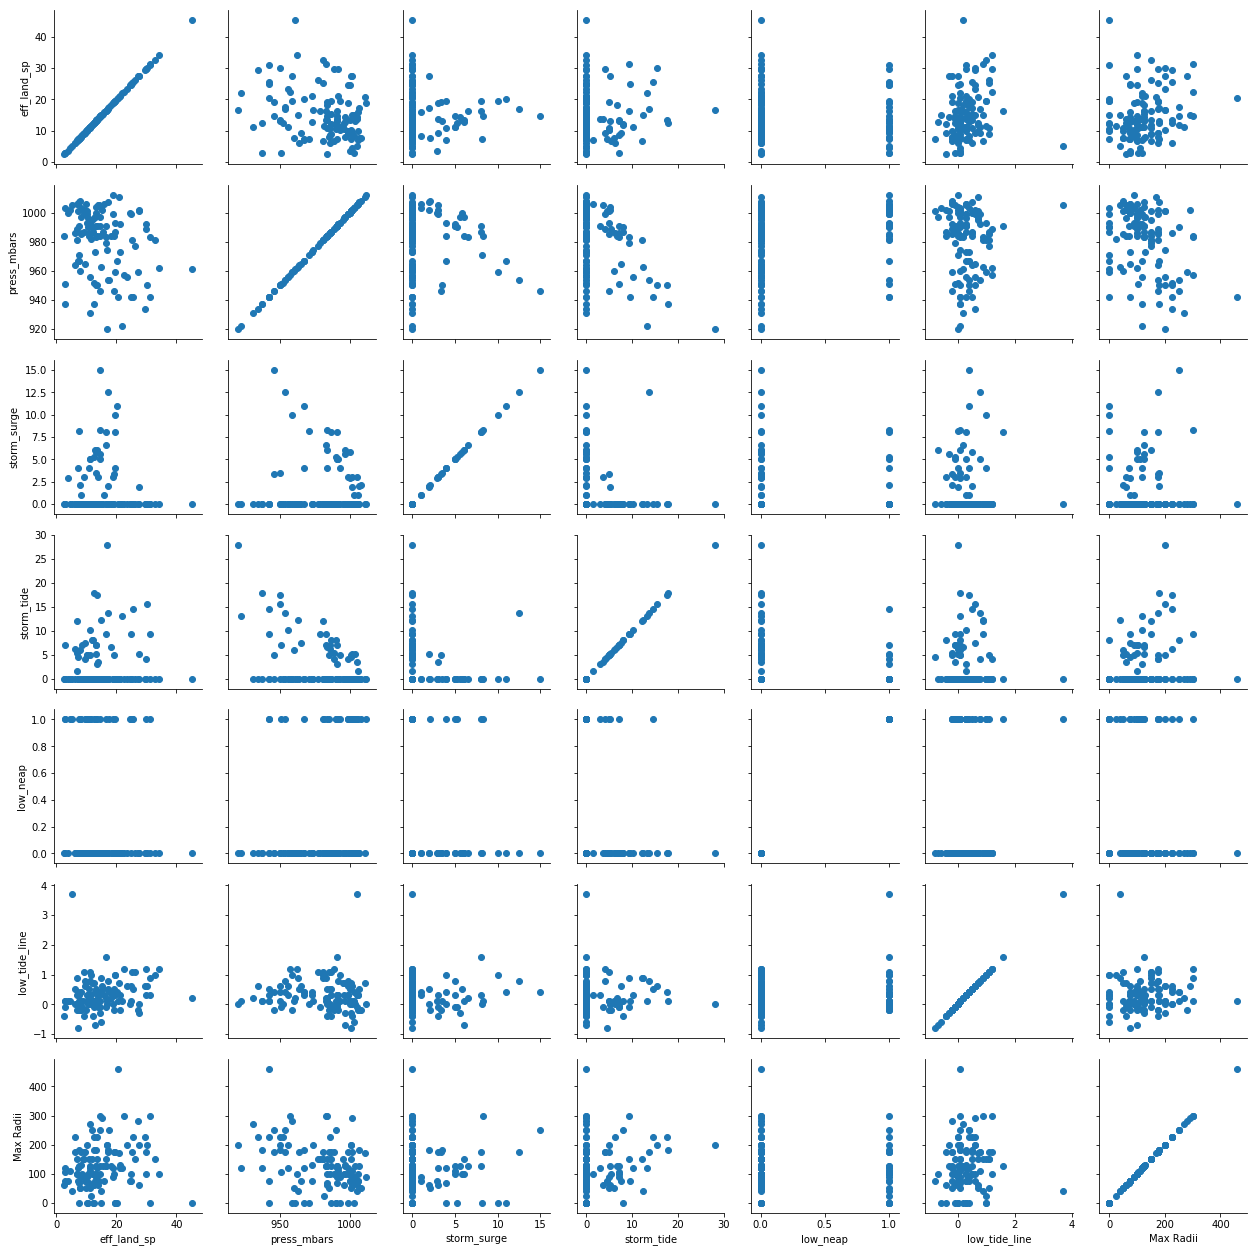

In [38]:
g = sns.PairGrid(X_rl[X_rl.columns[rfecv.support_]])
g.map(plt.scatter);

In [ ]:
# Dropping columns which are not selected in our RFE Test.
X_rl = X_rl[X_rl.columns[rfecv.support_]]
X_rl = X_rl.astype("float64")

In [ ]:
X_rl.info()

In [ ]:
# calculate the correlation matrix
corr = X_rl.corr()

cmap = sns.diverging_palette(5, 250, as_cmap=True)

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_precision(2)\

In [ ]:
# correlation map
print("\n----------")
f,ax = plt.subplots()
sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

### Understand Decision Trees and Feature Importance

In [ ]:
dtree = tree.DecisionTreeClassifier(max_depth = 10)
dtree.fit(X_rl, y_rl)

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
print(dict(zip(X_rl.columns, dtree.feature_importances_*100)))

In [ ]:
importances = dtree.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), X_rl.columns)
plt.xlabel('Relative Importance')
plt.show()

# Import SS Data

In [ ]:
# Loading Saffir Simpson Dataset
storm_ss_df = pd.read_csv("../data/storm_ss_norm.csv")
storm_ss_df["cost_category_num"] = storm_ss_df.cost_category.astype('category').cat.codes
storm_ss_df = storm_ss_df.fillna(0)
storm_ss_df.info()

In [ ]:
# X_ss -> features
# y_ss -> labels

X_ss = storm_ss_df.drop(columns={"storm_names","norm_cost","cost_category","cost_category_num"})
y_ss = storm_ss_df.cost_category_num
classes = storm_ss_df.cost_category

## Classifiers

In [ ]:
# Dividing X, y into train and test data by 80 events and 35 events 
X_train, X_test, y_train, y_test = train_test_split(X_ss, y_ss, test_size=0.33, random_state = 42) 

In [ ]:
ss_acc = []
ss_mse = []

names_ss = []
i = 0

while i < 30:
    # Dividing X, y into train and test data by 80 events and 35 events 
    X_train, X_test, y_train, y_test = train_test_split(X_ss, y_ss, test_size=0.33, random_state = 42) 

    for name, model in classifiers:
        names.append(name) 

        model.fit(X_train, y_train)
        y_pred= model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        #print("Model:\n%s\n\nAccuracy:\n%s\n"%(name, acc*100))
        ss_acc.append([name, acc])

        mse = mean_squared_error(y_test, y_pred)
        #print("Mean Squared Error:\n%s\n"%(mse))
        ss_mse.append([name, mse])
        
    i = i + 1
print("Done.")

In [ ]:
df_acc_ss = pd.DataFrame(ss_acc, columns = {"names", "acc"})

In [ ]:
df_acc_ss.groupby(df_acc_ss.acc).describe()

In [ ]:
df_mse_ss = pd.DataFrame(ss_mse, columns = {"names", "mse"})

In [ ]:
df_mse_ss.groupby(df_mse_ss.mse).describe()

# Comparing results

In [ ]:
ax = df_mse_ss.groupby(df_mse_ss.mse).mean().plot(figsize=(10,5), grid=True)
df_mse.groupby(df_mse_ss.mse).mean().plot(figsize=(10,5), grid=True, ax=ax)
ax.legend(['SS MSE', 'RL MSE'])

In [ ]:
ax = df_acc_ss.groupby(df_acc_ss.acc).mean().plot(figsize=(10,5), grid=True)
df_acc.groupby(df_acc_ss.acc).mean().plot(figsize=(10,5), grid=True, ax=ax)
ax.legend(['SS ACC', 'RL ACC'])

In [ ]:
# plot roc curve
from sklearn.metrics import roc_curve, auc

#f2 score rf
y_base = np.zeros(100945)
fig, ax = plt.subplots()
random = model
y_score=random.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
print(f'Area under curve: {roc_auc}')

# Plotting Baseline..
plt.plot([0,1],[0,1], color = 'blue')

ax.set_xlabel('FPR')
ax.set_ylabel('Recall');

In [ ]:
from sklearn.metrics import precision_recall_curve

#f1 score lr
random = random_models[3]
y_base = np.zeros(100945)

y_score=random.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# prc_auc = auc(fpr, tpr)
precision_base, recall_base, _ = precision_recall_curve(y_test, y_base)

# Plotting our Baseline..
fig, ax = plt.subplots()
plt.plot(precision_base, recall_base) #baseline model
plt.plot(precision, recall)
# sns.lineplot(fpr_base, tpr_base)
ax.set_xlabel('Precision')
ax.set_ylabel('Recall');
# print(f'Area under curve: {prc_auc}')